In [1]:
import warnings
warnings.filterwarnings("ignore")

## read the json file
import pandas as pd 
from dateutil.relativedelta import relativedelta
import os
import sys
sys.path.append('C:/Users/T430/.env/Lib/site-packages')
import gensim
from gensim import corpora, models
from gensim.models import Phrases
import numpy as np
import networkx as nx
import pylab as plt
import matplotlib.pyplot as plt
import random
from scipy.sparse import csc_matrix
import pyLDAvis.gensim

In [2]:
with open('nyt_data.txt') as f:
    documents = f.readlines()
documents = [x.strip().strip('\n').strip("'") for x in documents]
len(documents)

8447

In [3]:
# contains vocabs with rows as index
with open('nyt_vocab.txt') as f:
    vocabs = f.readlines()
    
vocabs = [x.strip().strip('\n').strip("'") for x in vocabs] 
len(vocabs)

vocabs=pd.DataFrame(vocabs)
vocabs.columns=['Token']
vocabs.reset_index(level=0, inplace=True)
vocabs=dict(zip(vocabs['index'],vocabs['Token']))

In [4]:
'''create matrix X''' # x is tdm
numDoc = 8447
numWord = 3012 
X = np.zeros([numWord,numDoc])

for col in range(len(documents)):
    for row in documents[col].split(','):
        X[int(row.split(':')[0])-1,col] = int(row.split(':')[1])

y=X.T
### creating Gensim corpus    
#scipy_csc_matrix = gensim.matutils.corpus2csc(corpus_1)
gensim_cor=gensim.matutils.Dense2Corpus(y,documents_columns=False)
corpus=list(gensim_cor)
dictionary=gensim.corpora.dictionary.Dictionary.from_corpus(corpus=corpus,id2word=vocabs)

In [5]:
dictionary[0]
dic_token=pd.DataFrame.from_dict(dictionary.id2token, orient='index')
dic_token.columns=['token']

In [6]:
n = len(dictionary)
tf_matrix={key: 0 for key in dic_token.token}
for vector in corpus:
    for element in vector:
        tf_matrix[dictionary[element[0]]] += element[1]

In [7]:
tf_matrix=pd.DataFrame(list(tf_matrix.items()), columns=['token', 'count_nos'])
tf_matrix=tf_matrix.set_index(['token'])

In [ ]:
### finding optimum number of clusters
#from gensim.models.coherencemodel import CoherenceModel

#results=list()
#for i in range(10,30,1):
#    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = dictionary, passes=50,eval_every=2,random_state=random.seed(1),iterations=500)
#    results.append(CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence())

LDA implementation with 25 topics

In [8]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=25, id2word = dictionary, passes=5,eval_every=3,random_state=random.seed(1),iterations=1)

topic_distribution=ldamodel.get_topics()
len(topic_distribution)
top_topics = ldamodel.top_topics(corpus)
tc = sum([t[1] for t in top_topics])
print('Topic coherence: %.3e' %tc)

Topic coherence: -3.308e+01


In [9]:
movies_vis_data=pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary,sort_topics=False,n_jobs=1)

C:\Users\ats\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [10]:
pyLDAvis.display(movies_vis_data)

In [11]:
phi=ldamodel.show_topics(num_topics=ldamodel.num_topics,num_words=len(dictionary.id2token),formatted=False)

phi_df=list()
for i in range(len(phi)):
    topic_df=pd.DataFrame(phi[i][1])        
    topic_df_ind= topic_df.set_index([0])
    topic_df_ind.columns=["Topic_"+str(phi[i][0]+1)]
    phi_df.append(topic_df_ind)
phi_df_joined=pd.concat(phi_df,axis=1)

In [12]:
lift = phi_df_joined*0;  sum1 = sum(tf_matrix.count_nos)
for i in range(phi_df_joined.shape[0]):
    for j in range(phi_df_joined.shape[1]):
        ptermtopic = 0; pterm = 0
        ptermtopic = phi_df_joined.iloc[i, j] # term i's probability of topic j membership
        pterm = tf_matrix.loc[phi_df_joined.index[i],'count_nos']/sum1 # marginal probability of term i's occurrence in corpus
        lift.iloc[i, j] = ptermtopic/pterm # so, lift is topic membership probability normalized by occurrence probability

----------------------Topic#1----------------------


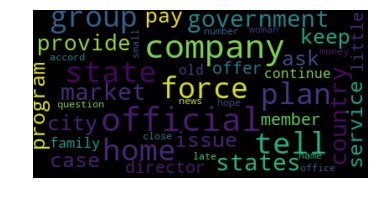

----------------------Topic#2----------------------


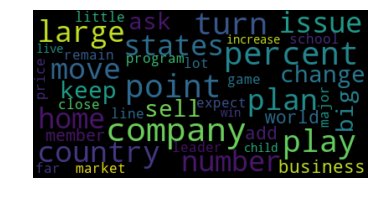

----------------------Topic#3----------------------


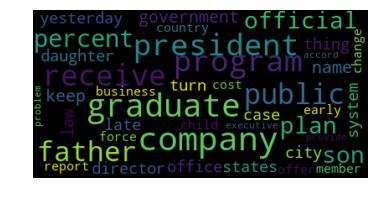

----------------------Topic#4----------------------


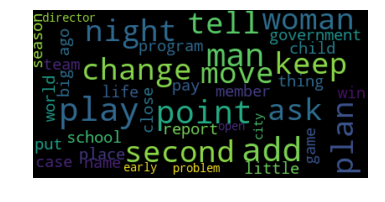

----------------------Topic#5----------------------


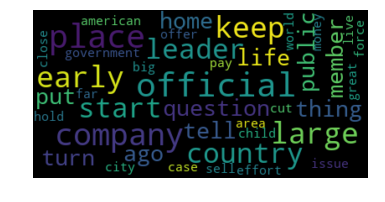

----------------------Topic#6----------------------


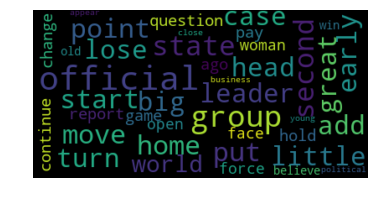

----------------------Topic#7----------------------


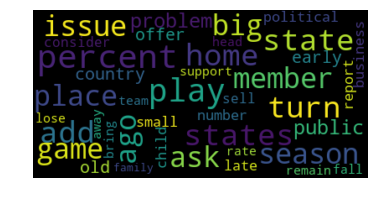

----------------------Topic#8----------------------


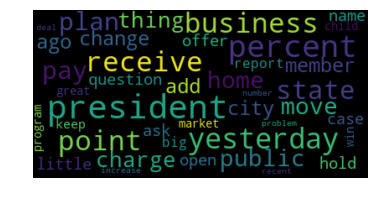

----------------------Topic#9----------------------


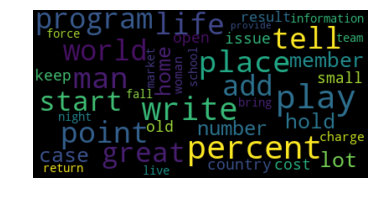

----------------------Topic#10----------------------


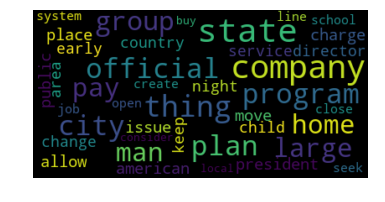

----------------------Topic#11----------------------


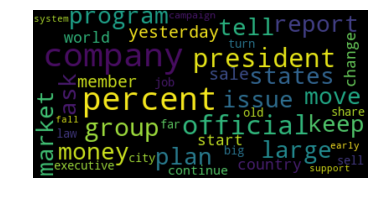

----------------------Topic#12----------------------


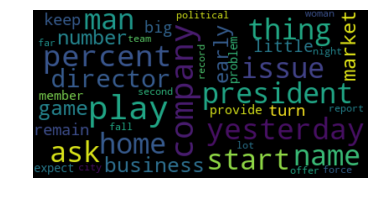

----------------------Topic#13----------------------


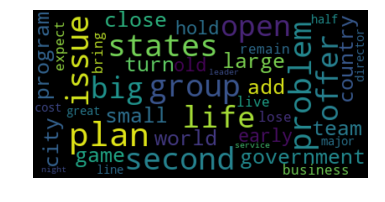

----------------------Topic#14----------------------


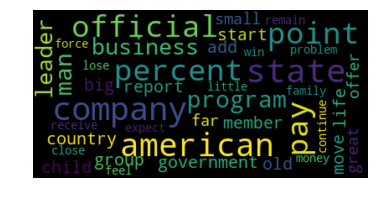

----------------------Topic#15----------------------


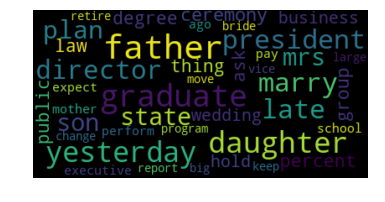

----------------------Topic#16----------------------


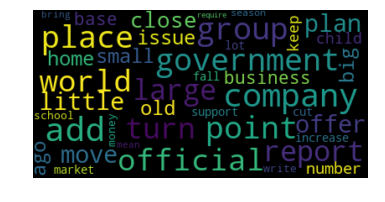

----------------------Topic#17----------------------


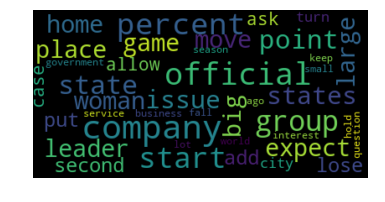

----------------------Topic#18----------------------


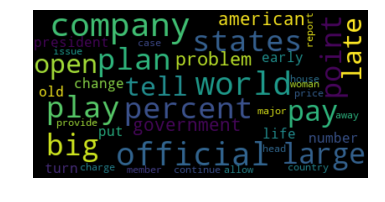

----------------------Topic#19----------------------


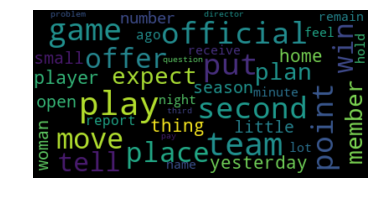

----------------------Topic#20----------------------


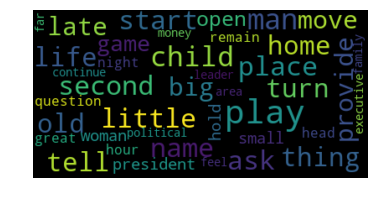

----------------------Topic#21----------------------


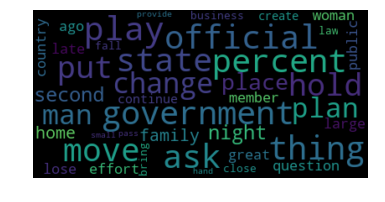

----------------------Topic#22----------------------


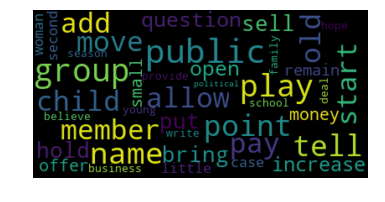

----------------------Topic#23----------------------


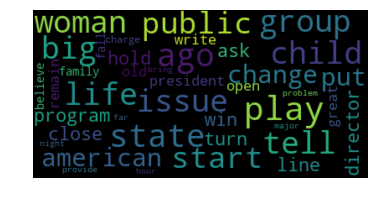

----------------------Topic#24----------------------


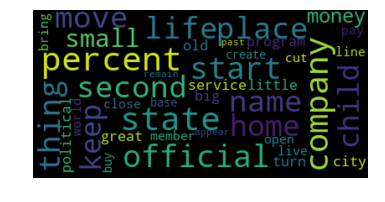

----------------------Topic#25----------------------


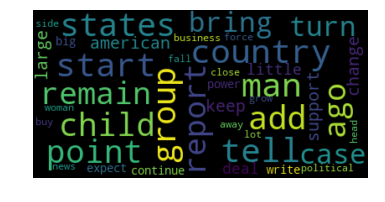

In [13]:
##plotting word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
for i in range(ldamodel.num_topics):
    print("----------------------Topic#"+str(i+1)+"----------------------") 
    lift_greater=lift.iloc[:,i]>1 # terms with lift greator than 1 for topic i
    freq=phi_df_joined.loc[lift_greater,:] #phi for terms greator than 1
    freq=freq.iloc[:,i].sort_values(ascending=False).to_frame() # Terms with higher probilities for topic i
    # Auto Correction -  Sometime terms in topic with lift above 1 are less than 100. So auto correction
    if(len(freq)>=40):
        n=40
    else: n=len(freq)
    freq.reset_index(inplace=True)
    freq_cloud=dict(zip(freq.iloc[0:n,0],freq.iloc[0:n,1]))
    wc=WordCloud(max_font_size=40).generate_from_frequencies(freq_cloud)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [14]:
### DTM formation Gensim    
from scipy.sparse import csc_matrix
scipy_csc_matrix = gensim.matutils.corpus2csc(corpus)
full_matrix = csc_matrix(scipy_csc_matrix).toarray()
full_matrix.shape
dictionary[0]
full_matrix=pd.DataFrame(full_matrix)
token_mapping=pd.DataFrame.from_dict(dictionary.id2token,orient='index')
token_mapping.columns=["Token"]
#mapping.reset_index(inplace=True)

full_matrix_1=pd.concat([token_mapping,full_matrix],axis=1) 
full_matrix_1=full_matrix_1.set_index(['Token'])    
full_matrix_tr=full_matrix_1.transpose()

Plotting the topic1


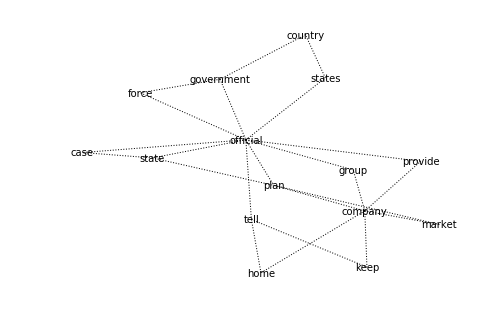

Plotting the topic2


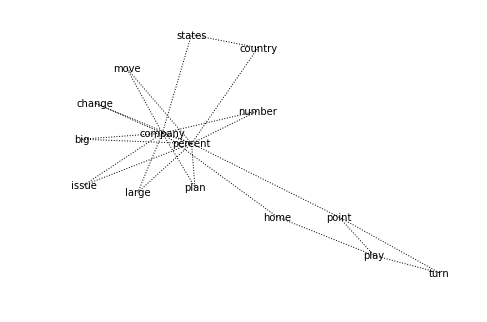

Plotting the topic3


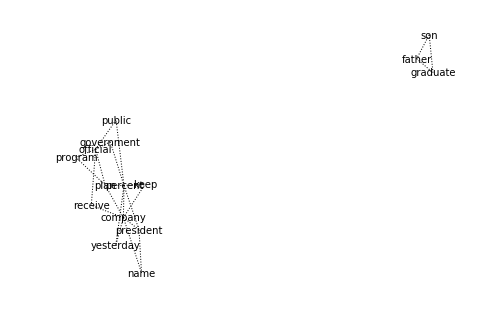

Plotting the topic4


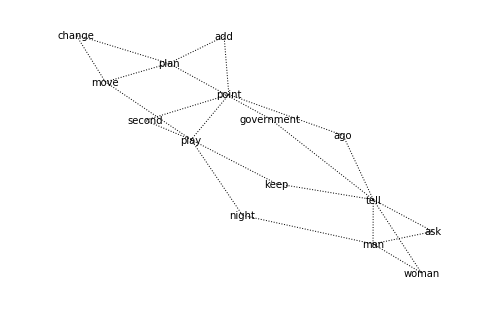

Plotting the topic5


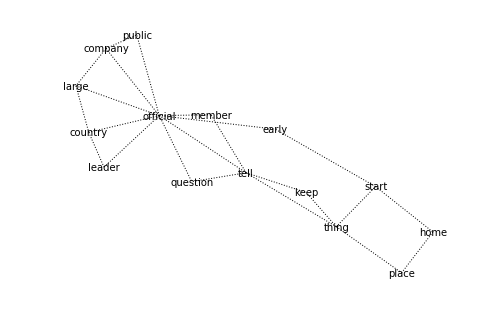

Plotting the topic6


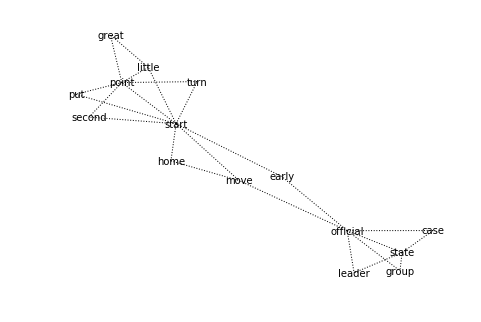

Plotting the topic7


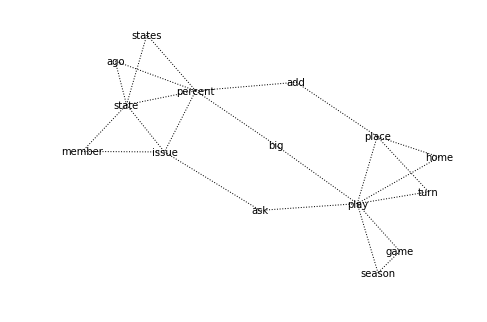

Plotting the topic8


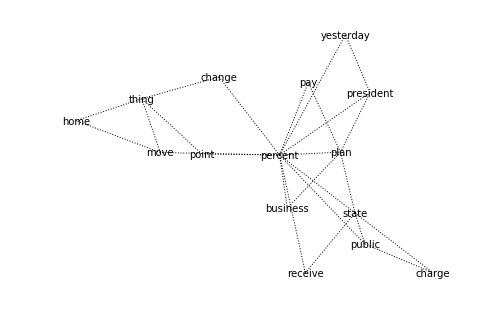

Plotting the topic9


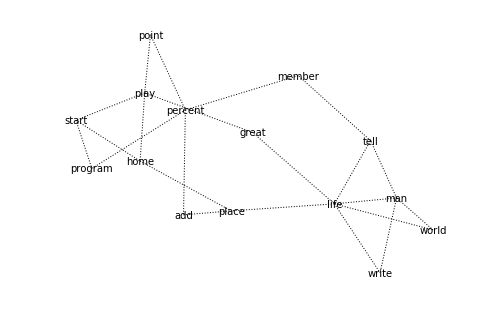

Plotting the topic10


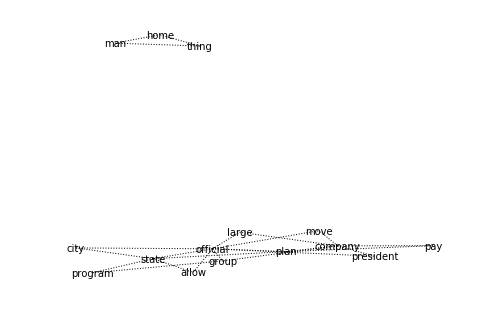

Plotting the topic11


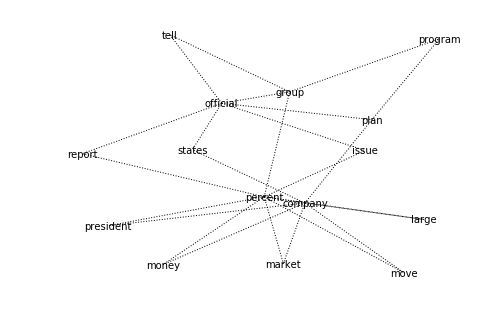

Plotting the topic12


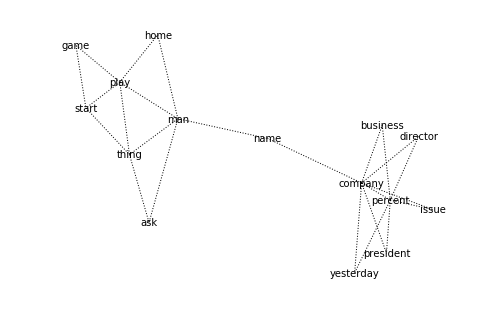

Plotting the topic13


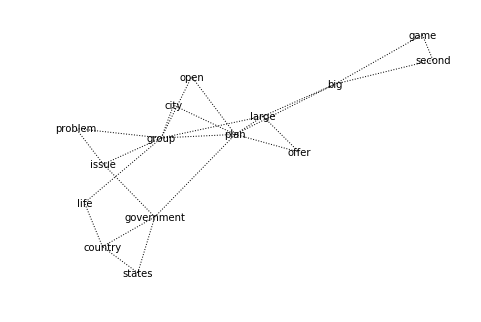

Plotting the topic14


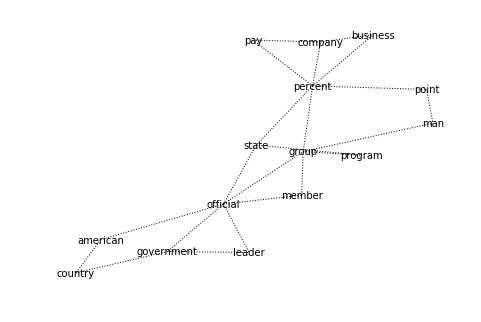

Plotting the topic15


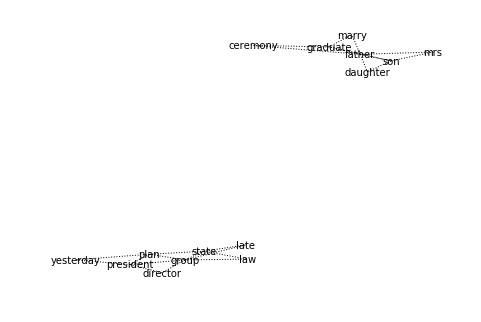

Plotting the topic16


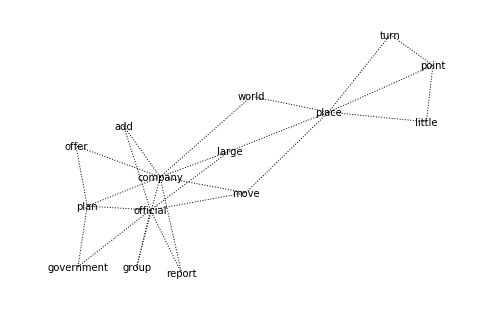

Plotting the topic17


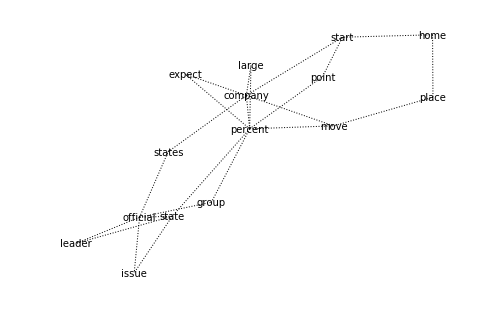

Plotting the topic18


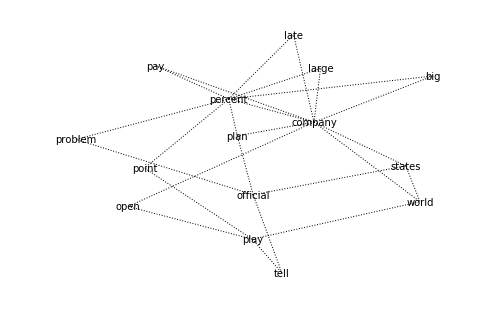

Plotting the topic19


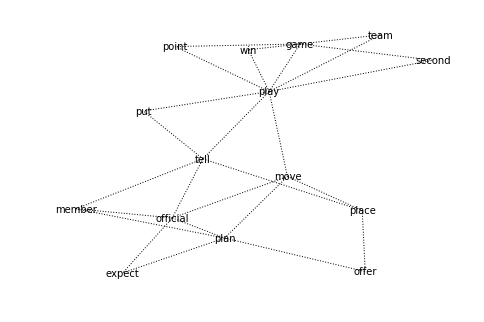

Plotting the topic20


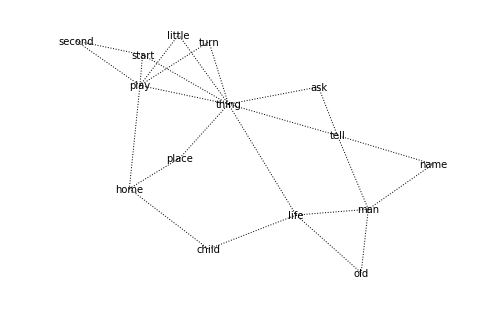

Plotting the topic21


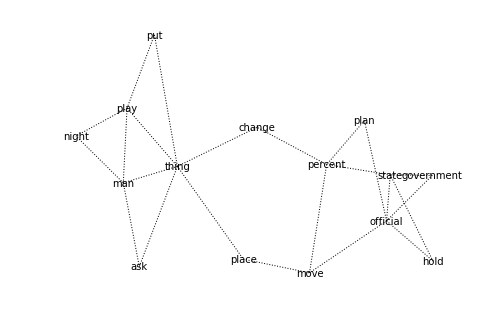

Plotting the topic22


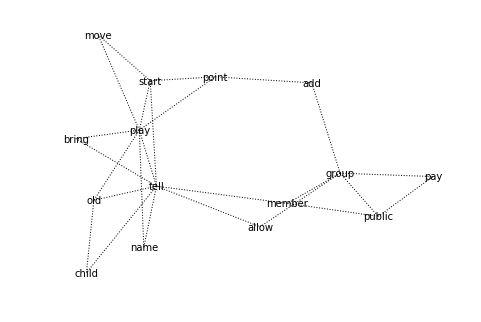

Plotting the topic23


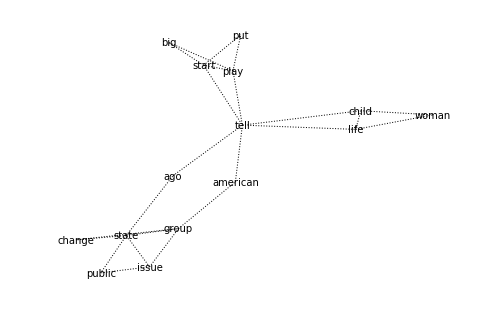

Plotting the topic24


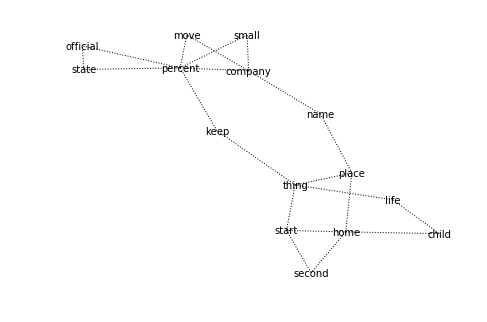

Plotting the topic25


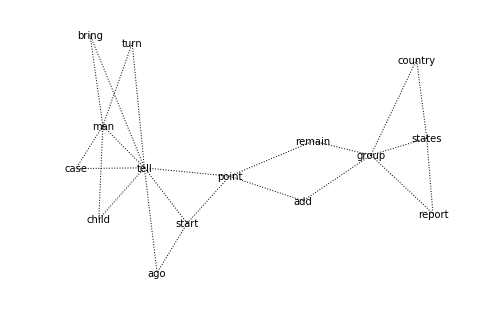

In [15]:
######co-occurance graphs
for i in range(ldamodel.num_topics):
    print("Plotting the topic"+str(i+1))
    lift_greater=lift.iloc[:,i]>1 # terms with lift greator than 1 for topic i
    freq=phi_df_joined.loc[lift_greater,:] #phi for terms greator than 1
    freq=freq.iloc[:,i].sort_values(ascending=False).to_frame() # Terms with higher probilities for topic i
    # Auto Correction -  Sometime terms in topic with lift above 1 are less than 100. So auto correction
    if(len(freq)>=15):
        n=15
    else: n=len(freq)
    freq.reset_index(inplace=True)
    freq=freq.iloc[0:n,:]
    # now for top 20 words let's find Document Term Matrix
    mat=full_matrix_tr.loc[:,list(freq['index'])]
    mat_transpose=mat.transpose()
    cmat=mat_transpose.dot(mat)
    cmat.values[[np.arange(n)]*2] = 0
    # Let's limit number of connections to 2
    for j in range(cmat.shape[1]):
        vec=cmat.iloc[j,:]
        cutoff=vec.sort_values(ascending=False)[1]
        if cutoff==0:
            continue
        cmat.iloc[j,list(np.where(cmat.iloc[j,:]<cutoff))]=0       
    cmat=cmat.unstack()
    cmat.index.names=['first','second']
    cmat=cmat.reset_index()
    cmat=cmat.rename(columns = {0:'weight'})
    cmat=cmat.sort_values(by='weight',axis=0,ascending=False)
    cmat=cmat.drop_duplicates(subset=['first', 'second'], keep="first")
    cmat=cmat.loc[~(cmat['weight']==0),:]
    cmat=cmat.loc[~(cmat['weight']==1),:]    
    G = nx.Graph()
    for row in cmat.iterrows():
        row=row[1]
        G.add_edge(row['first'], row['second'], weight=row['weight'])       
    nx.draw(G,with_labels = True,pos=nx.spring_layout(G),node_size=0,font_size=10,style='dotted',alpha=1)
#    plt.savefig("simple_path.png")
    plt.show()       